In [124]:
# the most coarse grained model
# state transition/Marcov model (maybe)
#
#Cseller

In [1]:
import pickle
import gzip
import matplotlib.pyplot as plt
import random
import warnings
import datafunctions
import definitions_2018 as bd
import displayfunctions as bp
import pandas as pd
import numpy as np
datafunctions.init(bd) 
bp.init(bd)

warnings.filterwarnings("ignore")

d:\desk\github_related\honey-bee-behavior\foraging_model\definitions_2018.py:20: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


Colors denote the different comb areas
Green – empty comb
Blue – brood
Dark blue – capped brood (we can/should probably just group all brood into one group)
Yellow – honey
Orange – pollen
Grey – peripheral galleries
Brown – wooden frames
Pink circles – dances observed during tracing (the general area is the dancefloor)


<font size='4'>Read and process data</font>

<font size='6'>State of bees considered:<br>
 'Honey', 'Brood care', 'Pollen', 'Dance floor', 'Other','Forage'</font>

<font size='6'>Train a Linear Regression Model</font>

In [33]:
#This model aims at minimizing the mean square error of cumulated delta forage
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def train_cumulative_mse_model(data, lag_periods, features,features_to_lag):
    def cumulative_mse_loss(params):
        model.coef_ = params[:-1]
        model.intercept_ = params[-1]
        
        y_pred = model.predict(X_train)
        
        y_train_cumsum = np.cumsum(y_train)
        y_pred_cumsum = np.cumsum(y_pred)
        cumulative_mse = np.sum(np.square(y_train_cumsum - y_pred_cumsum))
        return cumulative_mse
    lag_features = [f'{var}_lag_{i}' for var in features_to_lag for i in range(1, lag_periods + 1)]
    for feature in lag_features:
        data[feature] = data[feature.split('_')[0]].shift(int(feature.split('_')[2]))
    data = data.iloc[lag_periods:]
    
    train_size = int(0.8 * len(data))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    X_train = train_data[features + lag_features].iloc[:-1].values
    y_train = train_data['Forage'].diff().iloc[1:].values
    
    X_test = test_data[features + lag_features].iloc[:-1].values
    y_test = test_data['Forage'].diff().iloc[1:].values
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    initial_params = np.concatenate([model.coef_, [model.intercept_]])
    result = minimize(cumulative_mse_loss, initial_params, method='Nelder-Mead')
    
    optimized_params = result.x
    model.coef_ = optimized_params[:-1]
    model.intercept_ = optimized_params[-1]
    
    y_pred = model.predict(X_test)
    final_cumulative_mse = cumulative_mse_loss(optimized_params)
    
    plot_combined_actual_vs_predicted(model,data,features_to_lag)
    
    return {
        'model': model,
        'optimized_coefficients': model.coef_,
        'optimized_intercept': model.intercept_,
        'final_cumulative_mse': final_cumulative_mse
    }

def plot_combined_actual_vs_predicted(model,df_test,features_to_lag):

    lag_features = [f'{var}_lag_{i}' for var in features_to_lag for i in range(1, lag_periods + 1)]
    for feature in lag_features:
        df_test[feature] = df_test[feature.split('_')[0]].shift(int(feature.split('_')[2]))
    df_test = df_test.iloc[lag_periods:]
    X_test = df_test[features + lag_features].iloc[:-1].values
    y_test = df_test['Forage'].diff().iloc[1:].values

    # Make predictions on test data
    y_pred = model.predict(X_test)
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    y_test_cumsum = np.cumsum(y_test)
    y_pred_cumsum = np.cumsum(y_pred)
    # Plot actual vs. predicted values
    axes[0].plot(y_test, label='Actual')
    axes[0].plot(y_pred, linestyle='dashed', label='Predicted')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Value')
    ori_mse=np.sum(np.square(y_test - y_pred))/len(y_test)
    axes[0].set_title('Actual vs. Predicted Values mse={}'.format(ori_mse))
    axes[0].legend()
    # Plot cumulative actual vs. predicted values
    axes[1].plot(y_test_cumsum, label='Actual Cumulative')
    axes[1].plot(y_pred_cumsum, linestyle='dashed', label='Predicted Cumulative')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cumulative Value')
    cumulative_mse = np.sum(np.square(y_test_cumsum - y_pred_cumsum))/len(y_test)
    axes[1].set_title('Actual vs. Predicted Cumulative Values mse={}'.format(cumulative_mse))
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [3]:
df1min_dir='../df_day1min_alldays/'

In [4]:
#read train data
def process(df):
    numtimedivs = len(df['timedivision'].unique())
    day_uids, day_ages, all_inhive, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(df, numtimedivs=numtimedivs)
    columns_to_sum = ['Honey', 'Brood care', 'Pollen', 'Dance floor', 'Other']
    state_distribution_permin = df.groupby('timedivision')[columns_to_sum].sum()
    state_distribution_permin.reset_index(inplace=True)
    honey_sum = np.count_nonzero(all_inhive == 0, axis=0)
    state_distribution_permin['Forage'] = honey_sum
    return state_distribution_permin

df1min_dir='../df_day1min_alldays/'
day_train=44
df_train = process(pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(df1min_dir, day_train)))
# Train the model on train data

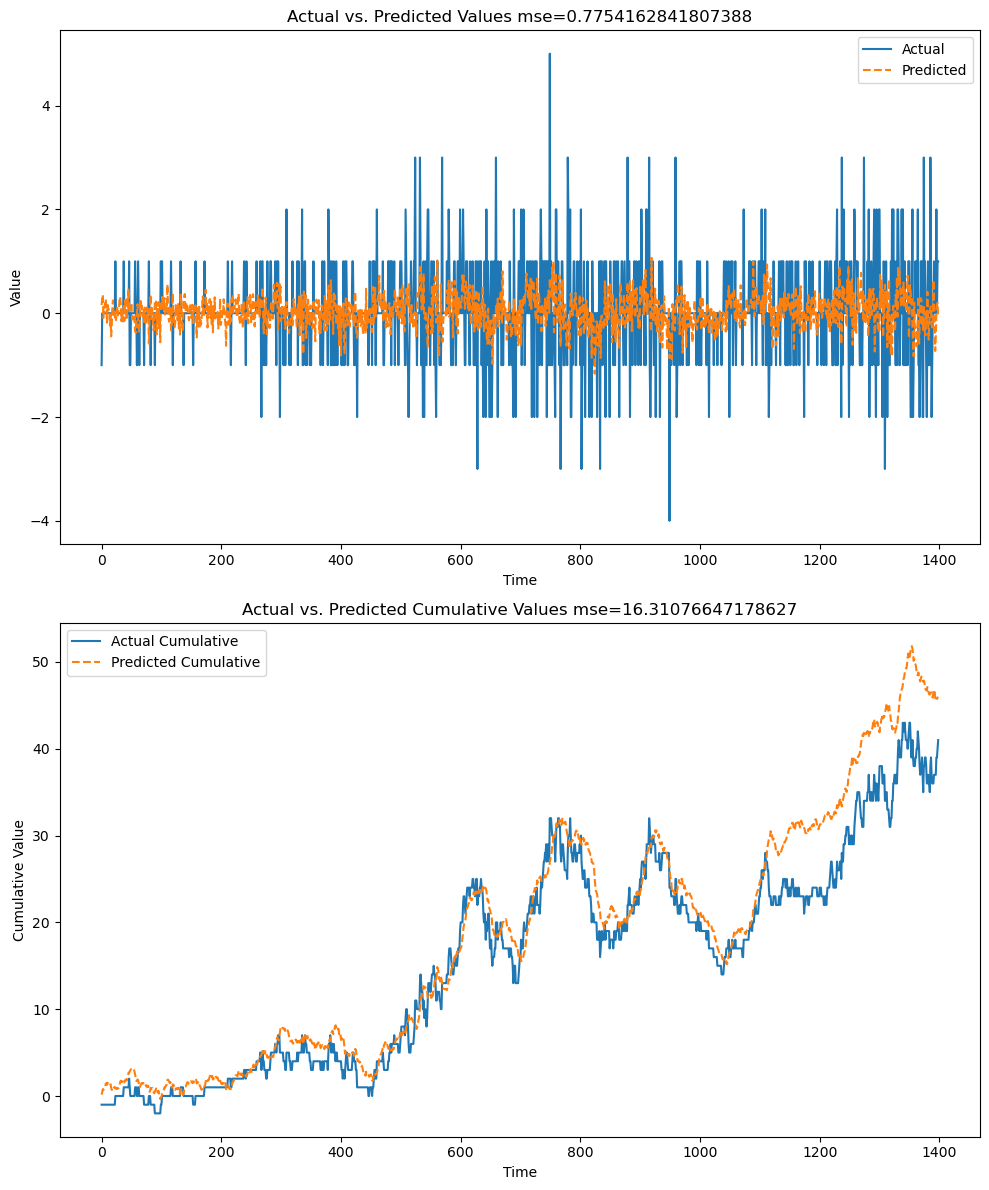

In [47]:
features=['Honey', 'Brood care', 'Pollen', 'Dance floor', 'Other','Forage']
lag_periods=20
features_to_lag=['Forage','Dance floor']
trained_model_info = train_cumulative_mse_model(df_train, lag_periods, features, features_to_lag)
model = trained_model_info['model']

In [16]:
day_test=45
df_test = process(pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(df1min_dir, day_test)))


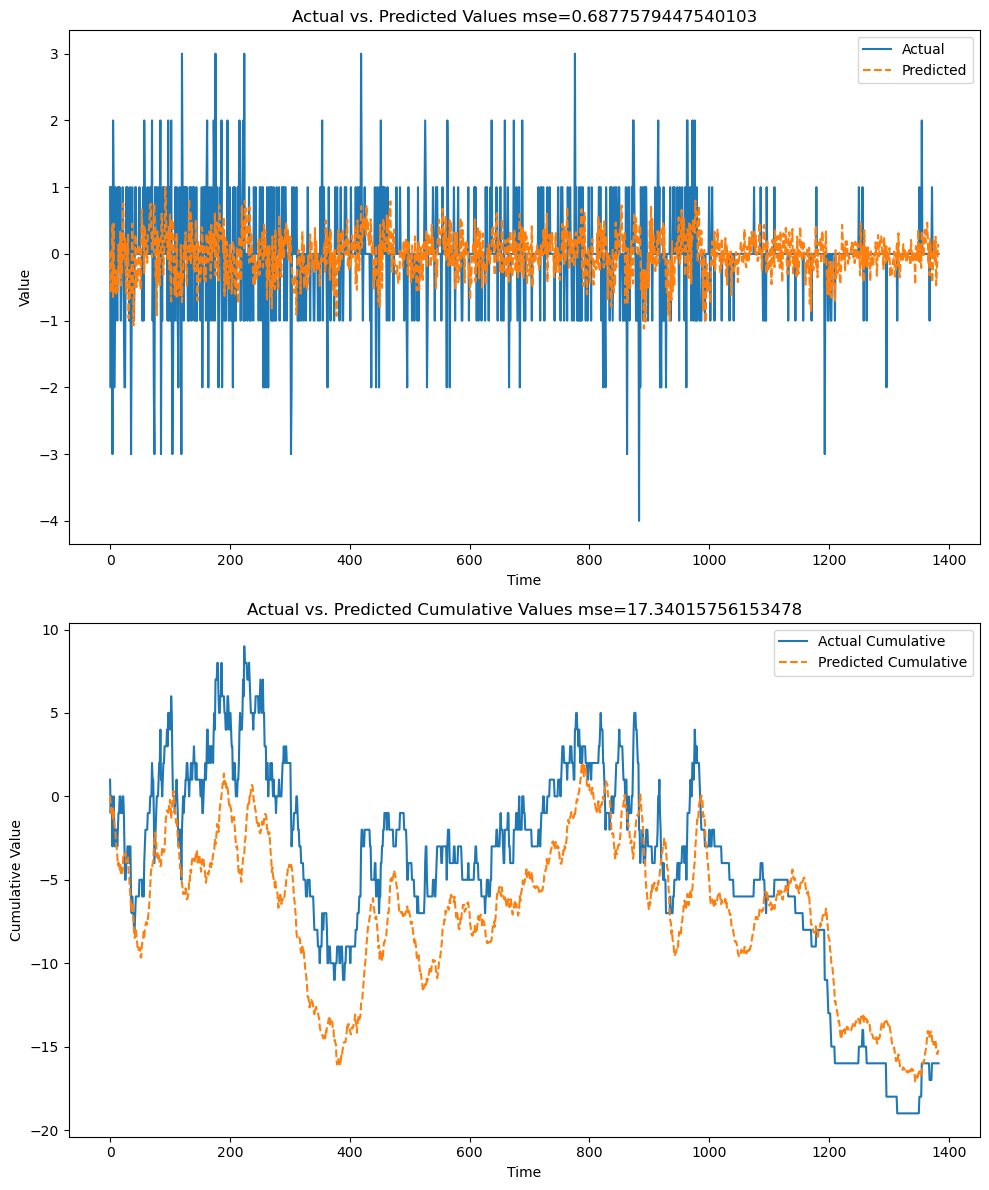

In [41]:
plot_combined_actual_vs_predicted(model,df_test,features_to_lag)

In [5]:
day_test_1=46
df_test1 = process(pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(df1min_dir, day_test_1)))


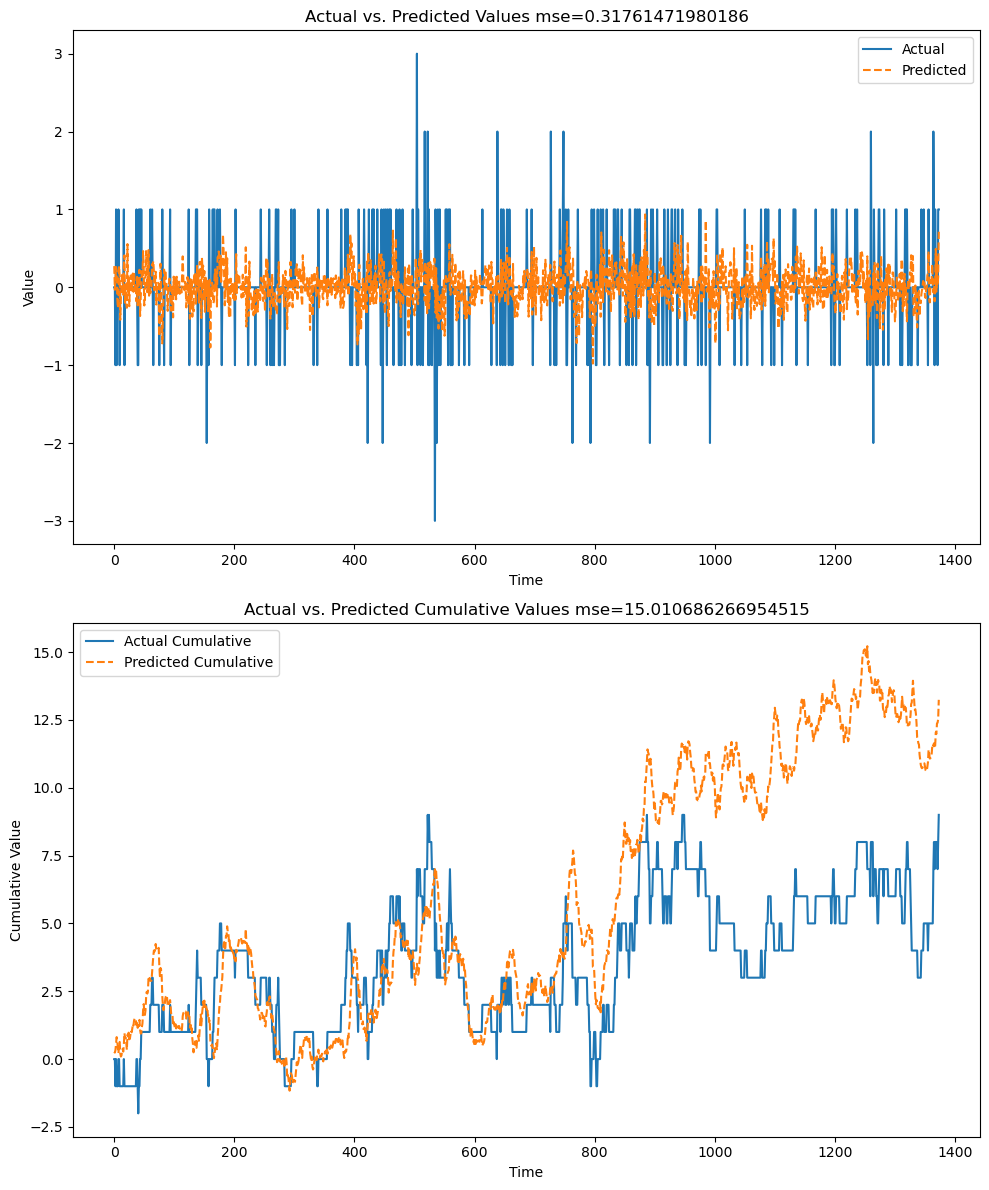

In [42]:
plot_combined_actual_vs_predicted(model,df_test1,features_to_lag)


In [48]:
coefficients = model.coef_
feature_names = features + lag_features
coeff_dict = dict(zip(feature_names, coefficients))
for feature, coefficient in coeff_dict.items():
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: Honey, Coefficient: 0.0012639647166567958
Feature: Brood care, Coefficient: 0.0005176262532594752
Feature: Pollen, Coefficient: 0.0006984630969219161
Feature: Dance floor, Coefficient: 0.012674428498641498
Feature: Other, Coefficient: -0.0015691308006369363
Feature: Forage, Coefficient: 0.038955285171816276
Feature: Forage_lag_1, Coefficient: -0.05703684027642994
Feature: Forage_lag_2, Coefficient: 0.06714653491459807
Feature: Forage_lag_3, Coefficient: 0.049608486651683686
Feature: Forage_lag_4, Coefficient: -0.05013727569674431
Feature: Forage_lag_5, Coefficient: 0.07153707803616882
Feature: Forage_lag_6, Coefficient: -0.09442059870833264
Feature: Forage_lag_7, Coefficient: 0.02525015572172344
Feature: Forage_lag_8, Coefficient: 0.06924289508666323
Feature: Forage_lag_9, Coefficient: -0.023157362018074473
Feature: Forage_lag_10, Coefficient: 0.011073355537888942
Feature: Forage_lag_11, Coefficient: -0.036452782839053066
Feature: Forage_lag_12, Coefficient: -0.069917477526496

In [30]:
day_test_2=27
df_test2 = process(pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(df1min_dir, day_test_2)))


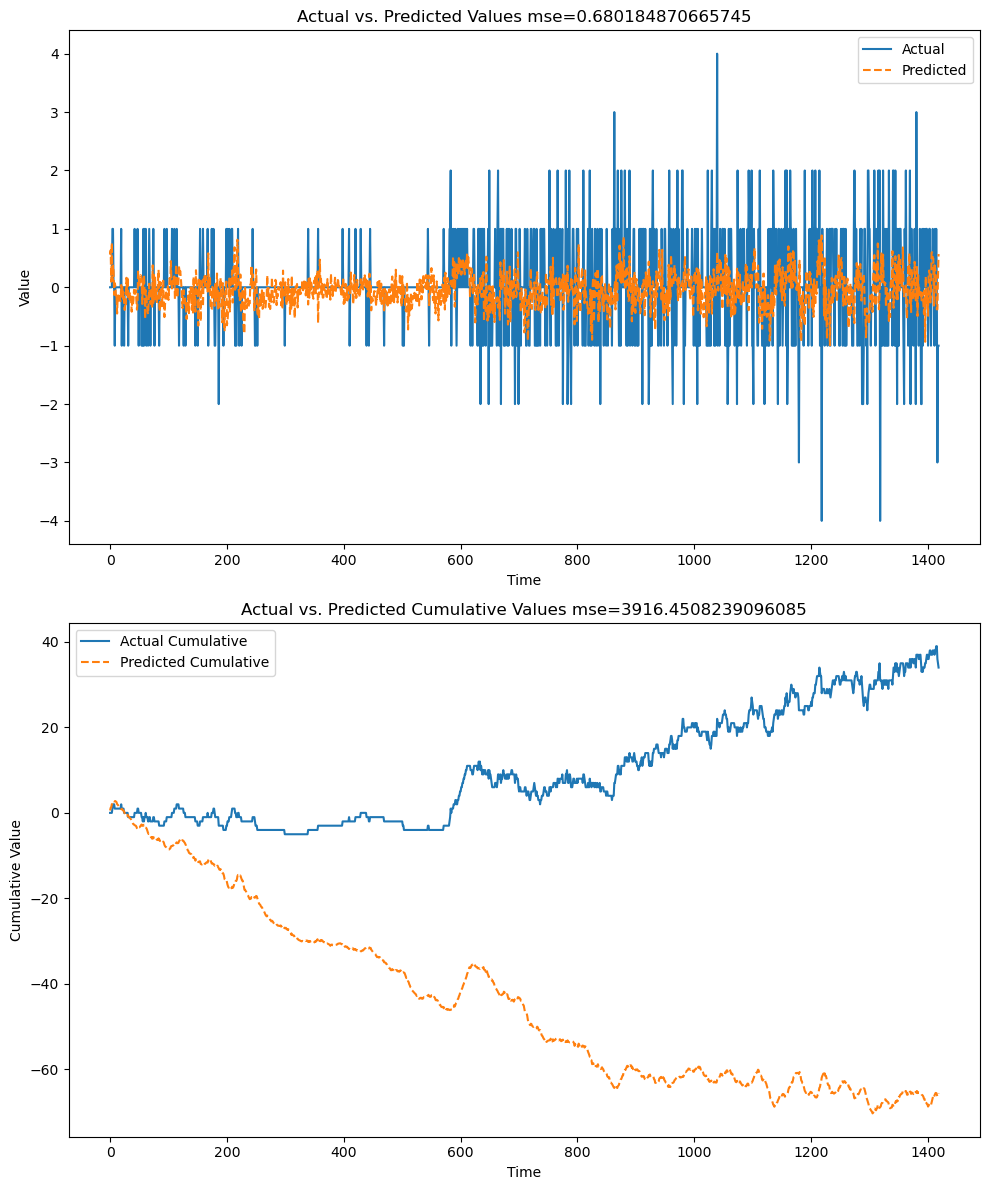

In [43]:
plot_combined_actual_vs_predicted(model,df_test2,features_to_lag)


In [ ]:

# Prepare test data
lag_features = [f'{var}_lag_{i}' for var in features_to_lag for i in range(1, lag_periods + 1)]
for feature in lag_features:
    df_test2[feature] = df_test2[feature.split('_')[0]].shift(int(feature.split('_')[2]))
df_test2 = df_test2.iloc[lag_periods:]
X_test = df_test2[features + lag_features].iloc[:-1].values
y_test = df_test2['Forage'].diff().iloc[1:].values

# Make predictions on test data
y_pred = model.predict(X_test)

# Plot combined actual vs. predicted values
plot_combined_actual_vs_predicted(y_test, y_pred)


# Example usage
# plot_combined_actual_vs_predicted(day_train=29, day_test=49, lag_periods=5, features=features)


In [21]:
df=pd.read_hdf("D:\desk\github_related\honey-bee-behavior\df_dayhour_alldays\df_dayhour_49.hdf")
# numtimedivs = len(df['Hour'].unique()) # minutes in a day
# day_uids, day_ages, all_inhive, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(df,numtimedivs=numtimedivs)

In [18]:
df.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'blank1', 'blank2', 'Bee unique ID', 'Cohort ID', 'Num. outside trips',
       'Num. dance floor visits', 'Dispersion-minute avg.',
       'Frame 0 - Num. crossings', 'Frame 1 - Num. crossings',
       'Frame 2 - Num. crossings', 'Frame 3 - Num. crossings',
       'Frame 4 - Num. crossings', 'Frame 5 - Num. crossings', 'Hour'],
      dtype='object')

In [24]:

# 使用布尔索引筛选 'Num. outside trips' 列不为 NaN 或不为 0 的行
non_zero_observations = df[(df['Num. outside trips'].notna()) & (df['Num. outside trips'] != 0)]

# 获取前 10 项
first_10_non_zero = non_zero_observations.head(10)

# 打印结果
print(first_10_non_zero)

     Age  Num. observations     Honey  Brood care    Pollen  Dance floor  \
4   44.0              382.0  0.000000    0.000000  0.000000     1.000000   
6   39.0              120.0  0.000000    0.000000  0.000000     1.000000   
11  34.0             1401.0  0.022025    0.028007  0.003909     0.838687   
15  34.0              119.0  0.000000    0.000000  0.000000     1.000000   
19  34.0               49.0  0.179786    0.000000  0.000000     0.000000   
20  34.0              701.0  0.062224    0.004619  0.000000     0.098431   
27  29.0              255.0  0.000000    0.000000  0.000000     1.000000   
58  23.0              108.0  0.613316    0.015432  0.081570     0.129630   
93  23.0              474.0  0.000000    0.000000  0.000000     1.000000   
97  23.0               14.0  0.000000    0.000000  0.000000     1.000000   

           Other  Frame 0   Frame 1   Frame 2  ...  Num. outside trips  \
4   0.000000e+00      0.0  0.000000  0.000000  ...                 1.0   
6   1.184238e-1

In [62]:
unique_count = df['uid'].unique()
print(unique_count)

[1978 2277 2539 ... 4232 3324 3672]


In [68]:
framenum_ranges = {}

# Iterate through each unique 'uid' value in unique_count
for uid_value in unique_count:
    # Filter the DataFrame based on the current 'uid' value
    filtered_df = df[df['uid'] == uid_value]
    
    # Calculate the minimum and maximum 'framenum' values within the filtered subset
    min_framenum = filtered_df['framenum'].min()
    max_framenum = filtered_df['framenum'].max()
    
    # Store the 'framenum' range in the dictionary
    framenum_ranges[uid_value] = (min_framenum, max_framenum)

# Print the 'framenum' ranges for each 'uid'
for uid_value, framenum_range in framenum_ranges.items():
    print(f"uid {uid_value}: framenum range {framenum_range}")

uid 1978: framenum range (3739, 4941)
uid 2277: framenum range (1797, 222170)
uid 2539: framenum range (2984, 255950)
uid 2630: framenum range (2672, 173584)
uid 2631: framenum range (6014, 248395)
uid 2749: framenum range (1051, 231407)
uid 2781: framenum range (3764, 256376)
uid 2901: framenum range (6337, 259196)
uid 2902: framenum range (2803, 236459)
uid 2945: framenum range (1451, 210596)
uid 3061: framenum range (3597, 255686)
uid 3140: framenum range (10531, 253423)
uid 3154: framenum range (1496, 252724)
uid 3157: framenum range (6882, 205320)
uid 3171: framenum range (1440, 257140)
uid 3186: framenum range (3312, 212282)
uid 3189: framenum range (7177, 259196)
uid 3190: framenum range (2376, 245819)
uid 3194: framenum range (3867, 252659)
uid 3230: framenum range (1061, 175634)
uid 3241: framenum range (5397, 236539)
uid 3255: framenum range (3597, 259199)
uid 3263: framenum range (0, 199573)
uid 3266: framenum range (315, 238241)
uid 3269: framenum range (7374, 234140)
uid 3

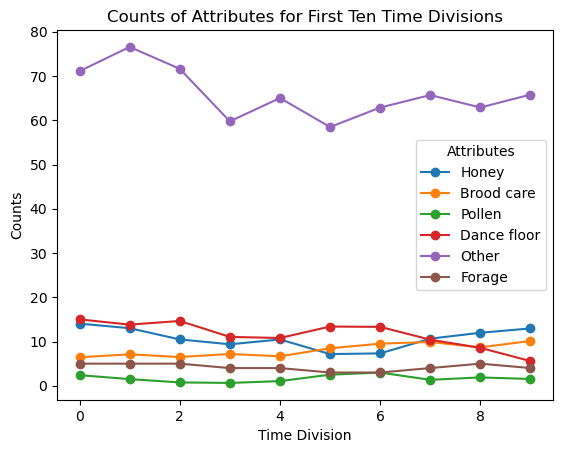

In [ ]:
import matplotlib.pyplot as plt

# Subset the grouped data for the first ten 'timedivision' values
subset_grouped = state_distribution_permin.head(10)

# Create a line chart
subset_grouped[columns_to_sum].plot(kind='line', marker='o')
# subset_grouped[['Frame 0', 'Frame 1', 'Frame 2', 'Frame 3', 'Frame 4', 'Frame 5']].plot(kind='line', marker='o')

# Add labels and title
plt.xlabel('Time Division')
plt.ylabel('Counts')
plt.title('Counts of Attributes for First Ten Time Divisions')
plt.legend(title='Attributes')

# Show the plot
plt.show()

In [85]:
filtered_df = df[df['uid'] == 1978]
print(filtered_df.iloc[70:90])
# num_rows = filtered_df.shape[0]
# print(num_rows)

    daynum  framenum   uid     x     y  camera     theta
70      49      3809  1978  1990  4879       0 -1.764870
71      49      3810  1978  1991  4879       0 -1.708790
72      49      3811  1978  1991  4879       0 -1.802350
73      49      3812  1978  1991  4879       0 -1.804090
74      49      3813  1978  1991  4879       0 -1.807370
75      49      3814  1978  2048  4919       0  2.828700
76      49      3815  1978  1991  4879       0 -1.766500
77      49      3816  1978  1991  4879       0 -1.735810
78      49      3817  1978  1991  4879       0 -1.723170
79      49      3823  1978  1991  4879       0 -1.713600
80      49      3834  1978  2056  4728       0  0.992218
81      49      3839  1978  2056  4728       0  0.941120
82      49      3840  1978  2055  4719       0 -2.547180
83      49      3841  1978  2055  4728       0 -0.271713
84      49      3843  1978  2055  4727       0 -2.244820
85      49      3850  1978  2055  4728       0 -0.680178
86      49      4608  1978  199